In [1]:
import os

os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
os.environ['PYTHONHASHSEED'] = str(24)

import random
import numpy as np
import torch

SEED = 24
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [2]:
test_tensor = torch.randn(5)
print(test_tensor)

tensor([ 1.0139,  0.8988, -0.2111, -1.5326, -0.6163])


In [3]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

username = 'Andrew_Reusche92'
api_key = '63cd28af853827307d2b6546dd833488'

api_token = {"username":username,"key":api_key}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!kaggle datasets download -d ronakgohil/license-plate-dataset

Dataset URL: https://www.kaggle.com/datasets/ronakgohil/license-plate-dataset
License(s): CC0-1.0
license-plate-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip -q license-plate-dataset.zip -d data

replace data/archive/classes.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [6]:
pip -q install scikeras

In [7]:
pip -q install keras-tuner

In [8]:
import os
import cv2
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import shutil
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

# data import and exploration

In [9]:
#data paths
image_dir = 'data/archive/images/train'
label_dir = 'data/archive/labels/train'

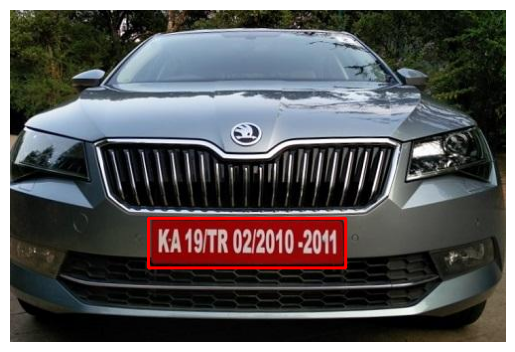

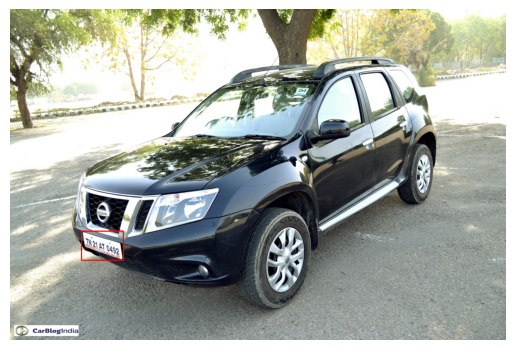

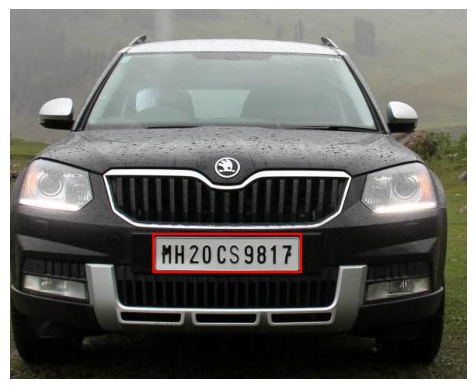

In [10]:
#deal with label paths that end in '.txt.txt'
def clean_label_path(label_path):
    if label_path.endswith('.txt.txt'):
        return label_path.replace('.txt.txt', '.txt')
    return label_path

#show images with boxes
def show_images_with_boxes(image_path, label_path, return_img= False):
  label_path= clean_label_path(label_path)
  img= cv2.imread(image_path)
  img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  h, w, _= img.shape

  with open(label_path, 'r') as f:
    boxes= f.readlines()

  for box in boxes:
    class_id, x_center, y_center, box_w, box_h= map(float, box.strip().split())
    x1= int((x_center - box_w / 2) *w)
    y1= int((y_center - box_h / 2) *h)
    x2= int((x_center + box_w / 2) *w)
    y2= int((y_center + box_h / 2) *h)
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

  if return_img:
    return img
  else:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

#show some examples
sample_imgs= sorted(os.listdir(image_dir))[:3]

for img_file in sample_imgs:
  label_file= os.path.splitext(img_file)[0] + '.txt'
  label_path= os.path.join(label_dir, label_file)
  image_path= os.path.join(image_dir, img_file)

  show_images_with_boxes(image_path, label_path)

In [11]:
#count the images in each directory
train_imgs= glob('data/archive/images/train/*.jpg')
train_labels= glob('data/archive/labels/train/*.txt')
val_imgs= glob('data/archive/images/val/*.jpg')
val_labels= glob('data/archive/labels/val/*.txt')

print('Train images:', len(train_imgs))
print('Train labels:', len(train_labels))
print('Validation images:', len(val_imgs))
print('Validation labels:', len(val_labels))

Train images: 1526
Train labels: 1526
Validation images: 169
Validation labels: 169


In [12]:
#make sure every image has a matching label file
def check_missing_labels(img_paths, label_dir):
    missing= []
    for img_path in img_paths:
        base= os.path.splitext(os.path.basename(img_path))[0]
        label_path= os.path.join(label_dir, base + ".txt")
        if not os.path.exists(label_path):
            missing.append(img_path)
    return missing

missing_train= check_missing_labels(train_imgs, 'data/archive/labels/train')
missing_val= check_missing_labels(val_imgs, 'data/archive/labels/val')

print(f"Missing labels in training set: {len(missing_train)}")
print(f"Missing labels in validation set: {len(missing_val)}")

Missing labels in training set: 0
Missing labels in validation set: 0


In [13]:
#check out bounding box size distribution
def get_bbox_dims(label_files):
    widths= []
    heights= []
    for lbl in label_files:
        with open(lbl, 'r') as f:
            for line in f.readlines():
                parts= line.strip().split()
                if len(parts) == 5:
                    _, _, _, w, h= map(float, parts)
                    widths.append(w)
                    heights.append(h)
    return pd.DataFrame({'width': widths, 'height': heights})

bbox_df= get_bbox_dims(train_labels + val_labels)
bbox_df.describe()

,width,height
count,1695.000000,1695.000000
mean,0.288975,0.103054
std,0.117831,0.076331
min,0.051471,0.021452
25%,0.216295,0.057851
50%,0.272059,0.082589
75%,0.337444,0.123077
max,0.996667,0.934483


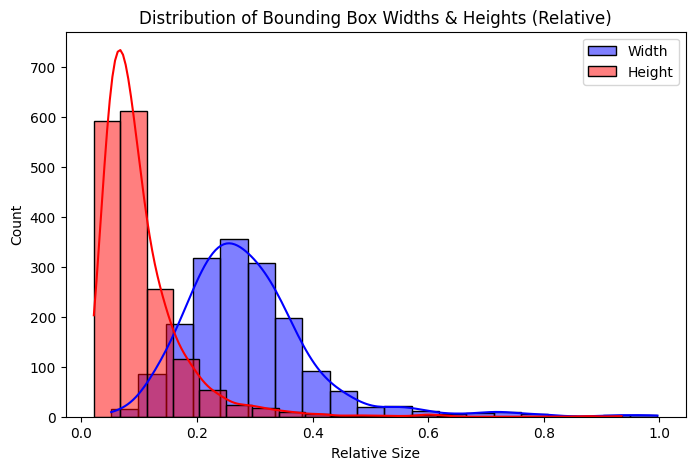

In [14]:
#plot the bounding box distribution
plt.figure(figsize=(8, 5))
sns.histplot(bbox_df['width'], bins=20, kde=True, color='blue', label='Width')
sns.histplot(bbox_df['height'], bins=20, kde=True, color='red', label='Height')
plt.title("Distribution of Bounding Box Widths & Heights (Relative)")
plt.xlabel("Relative Size")
plt.legend()
plt.show()

In [15]:
#inspect distribution of image sizes
def get_image_sizes(image_paths):
    widths= []
    heights= []
    for path in tqdm(image_paths):
      with Image.open(path) as img:
        w, h= img.size
        widths.append(w)
        heights.append(h)

    return pd.DataFrame({'width': widths, 'height': heights})

all_imgs= train_imgs + val_imgs
img_dims_df= get_image_sizes(all_imgs)

print(img_dims_df.describe())

100%|██████████| 1695/1695 [00:00<00:00, 13072.47it/s]

             width       height
count  1695.000000  1695.000000
mean    654.546313   554.525664
std     499.585320   321.803263
min      78.000000    87.000000
25%     272.000000   333.000000
50%     485.000000   451.000000
75%     859.500000   734.000000
max    4000.000000  3000.000000


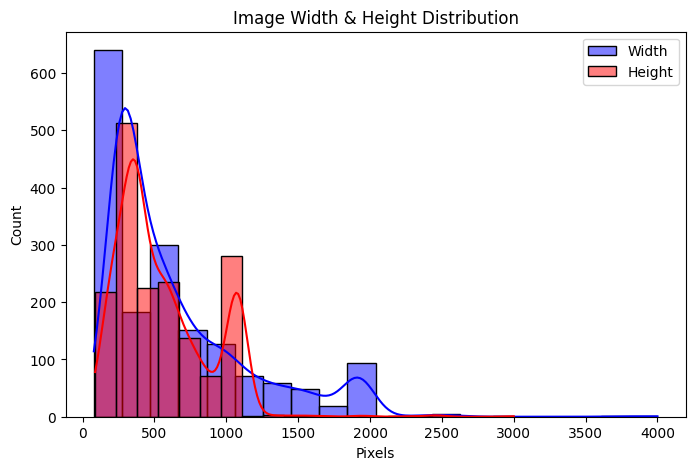

In [16]:
plt.figure(figsize=(8, 5))
sns.histplot(img_dims_df['width'], bins=20, kde=True, color='blue', label='Width')
sns.histplot(img_dims_df['height'], bins=20, kde=True, color='red', label='Height')
plt.title("Image Width & Height Distribution")
plt.xlabel("Pixels")
plt.legend()
plt.show()

In [17]:
#check out the class distribution to confirm they are all "license plate"
with open("data/archive/classes.txt", "r") as f:
    classes= f.read().splitlines()

print(f"Classes ({len(classes)}): {classes}")

Classes (1): ['license_plate']


# data preprocessing

## letterbox resizing (padded resize)

In [18]:
#define input and output file paths
input_img_dir= "data/archive/images/train"
input_lbl_dir= "data/archive/labels/train"

output_img_dir= "data/processed/images"
output_lbl_dir= "data/processed/labels"

os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_lbl_dir, exist_ok=True)

In [19]:
#define target dimensions
target_w= 620
target_h= 512

In [20]:
#function to resize the images
def letterbox_resize(image, target_width, target_height):
    h, w= image.shape[:2]
    scale= min(target_width / w, target_height / h)
    new_w= int(w * scale)
    new_h= int(h * scale)

    resized= cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    pad_w= target_width - new_w
    pad_h= target_height - new_h
    top= pad_h // 2
    bottom= pad_h - top
    left= pad_w // 2
    right= pad_w - left

    padded= cv2.copyMakeBorder(resized,
                                top,
                                bottom,
                                left,
                                right,
                                cv2.BORDER_CONSTANT,
                                value=(114, 114, 114))

    return padded, scale, left, top, w, h

#function to resize the labels
def process_labels(label_path, scale, pad_left, pad_top, orig_w, orig_h):
    new_lines= []

    with open(label_path, 'r') as f:
        lines= f.readlines()

    for line in lines:
        class_id, x, y, w, h= map(float, line.strip().split())

        #undo YOLO normalization
        x *= orig_w
        y *= orig_h
        w *= orig_w
        h *= orig_h

        #scale
        x *= scale
        y *= scale
        w *= scale
        h *= scale

        #add padding offset
        x += pad_left
        y += pad_top

        #re-normalize
        x /= target_w
        y /= target_h
        w /= target_w
        h /= target_h

        new_lines.append(f"{int(class_id)} {x:.6f} {y:.6f} {w:.6f} {h:.6f}")

    return new_lines

#function to preprocess data subset
def preprocess_yolo_dataset(input_img_dir,
                            input_lbl_dir,
                            output_img_dir,
                            output_lbl_dir,
                            target_w=640,
                            target_h=512):

    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_lbl_dir, exist_ok=True)

    image_files= [f for f in os.listdir(input_img_dir)
                 if f.lower().endswith('.jpg')]

    for img_file in tqdm(image_files, desc=f"Preprocessing {os.path.basename(input_img_dir)}"):
        img_path= os.path.join(input_img_dir, img_file)
        label_filename= os.path.splitext(img_file)[0] + '.txt'
        label_path= os.path.join(input_lbl_dir, label_filename)

        image= cv2.imread(img_path)

        pad_img, scale, pad_left, pad_top, orig_w, orig_h= letterbox_resize(image,
                                                                            target_w,
                                                                            target_h)

        #save the padded image
        out_img_path= os.path.join(output_img_dir, img_file)
        cv2.imwrite(out_img_path, pad_img)

        #process and save image
        if os.path.exists(label_path):
            new_label_lines = process_labels(label_path,
                                             scale,
                                             pad_left,
                                             pad_top,
                                             orig_w,
                                             orig_h)

            out_lbl_path= os.path.join(output_lbl_dir,
                                        label_filename)

            with open(out_lbl_path, 'w') as f:
                f.write('\n'.join(new_label_lines))

In [21]:
#preprocess the train subset
preprocess_yolo_dataset(input_img_dir= 'data/archive/images/train',
    input_lbl_dir= 'data/archive/labels/train',
    output_img_dir= 'data/processed/images',
    output_lbl_dir= 'data/processed/labels')

#preprocess the validation subset
preprocess_yolo_dataset(input_img_dir= 'data/archive/images/val',
    input_lbl_dir= 'data/archive/labels/val',
    output_img_dir= 'data/processed_val/images',
    output_lbl_dir= 'data/processed_val/labels')

Preprocessing val: 100%|██████████| 169/169 [00:01<00:00, 123.93it/s]


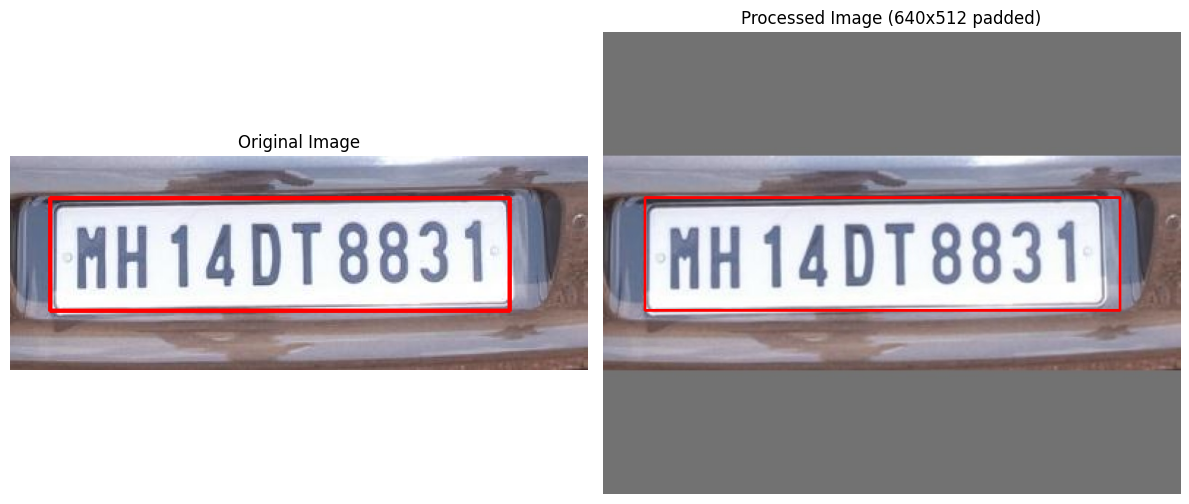

In [22]:
#create function to show image and bounding box before and after transformation
def show_images_side_by_side(img1_path, lbl1_path, img2_path, lbl2_path):
    img1= show_images_with_boxes(img1_path, lbl1_path, return_img=True)
    img2= show_images_with_boxes(img2_path, lbl2_path, return_img=True)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title("Processed Image (640x512 padded)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

#show before and after example from subset of uncomplicated file names
image_files= [f for f in os.listdir(input_img_dir) if f.lower().endswith('.jpg')]
trans_example= sorted(image_files)[8]
#fix label name edge cases
label_filename= os.path.splitext(trans_example)[0] + '.txt'


show_images_side_by_side(os.path.join(input_img_dir, trans_example),
                         os.path.join(input_lbl_dir, label_filename),
                         os.path.join(output_img_dir, trans_example),
                         os.path.join(output_lbl_dir, label_filename))

# Train Val Test Split

In [23]:
#preprocessed data paths
processed_train_img_dir= 'data/processed/images'
processed_train_lbl_dir= 'data/processed/labels'
processed_val_img_dir= 'data/processed_val/images'
processed_val_lbl_dir= 'data/processed_val/labels'

#output split base directory
split_base= 'data/final_split'
os.makedirs(split_base, exist_ok= True)

#get all preprocessed image-label pairs
train_images= sorted([f for f in os.listdir(processed_train_img_dir)
              if f.endswith('.jpg')])
train_pairs= [(f, os.path.splitext(f)[0] + '.txt') for f in train_images]

#train test split
train_split, test_split = train_test_split(train_pairs,
                                           test_size=0.1,
                                           random_state=24)
#copy image-label pairs to split directories
def copy_split(pairs, dest_split, src_img_dir, src_lbl_dir):
    img_out= os.path.join(split_base, dest_split, 'images')
    lbl_out= os.path.join(split_base, dest_split, 'labels')
    os.makedirs(img_out, exist_ok=True)
    os.makedirs(lbl_out, exist_ok=True)

    for img_file, lbl_file in tqdm(pairs, desc=f"Copying {dest_split}"):
        shutil.copy(os.path.join(src_img_dir, img_file),
                    os.path.join(img_out, img_file))
        shutil.copy(os.path.join(src_lbl_dir, lbl_file),
                    os.path.join(lbl_out, lbl_file))

#copy final splits
copy_split(train_split, 'train', processed_train_img_dir, processed_train_lbl_dir)
copy_split(test_split, 'test', processed_train_img_dir, processed_train_lbl_dir)

#copy preprocessed validation set as-is
val_pairs= [(f, os.path.splitext(f)[0] + '.txt')
            for f in os.listdir(processed_val_img_dir) if f.endswith('.jpg')]

copy_split(val_pairs, 'val', processed_val_img_dir, processed_val_lbl_dir)

#print the sizes from each split
print("\nTrain size:", len(os.listdir('data/final_split/train/images')))
print("Val size:  ", len(os.listdir('data/final_split/val/images')))
print("Test size: ", len(os.listdir('data/final_split/test/images')))

Copying val: 100%|██████████| 169/169 [00:00<00:00, 2169.20it/s]


Train size: 1373
Val size:   169
Test size:  153


## Create a Pytorch Dataset for Bounding Boxes

In [24]:
class LicensePlateDataset(Dataset):
  def __init__(self, image_dir, label_dir, transform= None):
    self.image_dir= image_dir
    self.label_dir= label_dir
    self.image_files= sorted([f for f in os.listdir(image_dir)
                              if f.endswith('.jpg')])
    self.transform= transform

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, idx):
    img_file= self.image_files[idx]
    label_file= os.path.splitext(img_file)[0] + '.txt'

    image_path= os.path.join(self.image_dir, img_file)
    label_path= os.path.join(self.label_dir, label_file)

    image= Image.open(image_path).convert('RGB')

    with open(label_path, 'r') as f:
      line= f.readline().strip()
      parts= line.split()
      bbox= torch.tensor(list(map(float, parts[1:])), dtype= torch.float32)

    if self.transform:
      image= self.transform(image)

    return image, bbox

In [25]:
transform= transforms.Compose([transforms.ToTensor(), ])

#path
base_path= 'data/final_split'

train_dataset= LicensePlateDataset(os.path.join(base_path, 'train/images'),
                                    os.path.join(base_path, 'train/labels'),
                                    transform=transform)

val_dataset= LicensePlateDataset(os.path.join(base_path, 'val/images'),
                                  os.path.join(base_path, 'val/labels'),
                                  transform=transform)

test_dataset= LicensePlateDataset(os.path.join(base_path, 'test/images'),
                                   os.path.join(base_path, 'test/labels'),
                                   transform=transform)

#data loaders
train_loader= DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader= DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader= DataLoader(test_dataset, batch_size=32, shuffle=False)

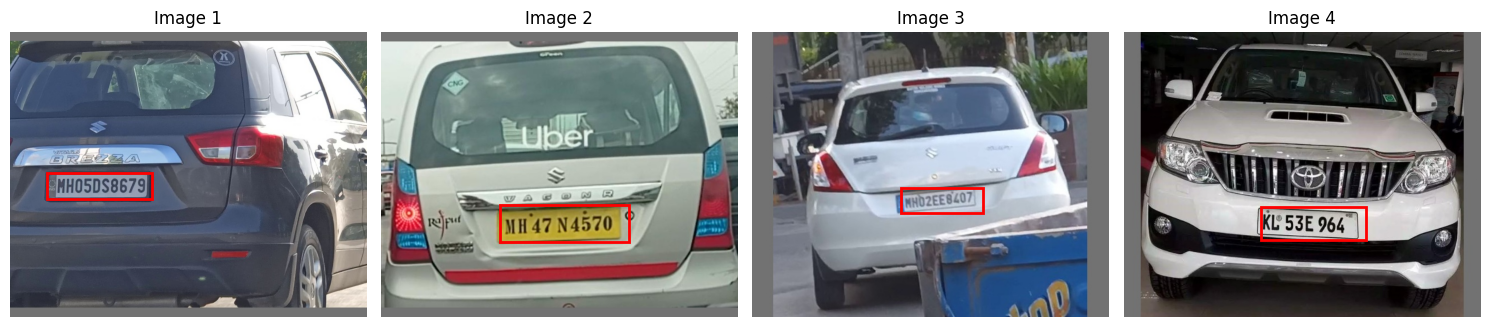

In [26]:
#preview transformed sample with bounding boxes
def show_batch_with_boxes(dataloader, batch_size= 4):
    images, bboxes= next(iter(dataloader))
    images= images[:batch_size]
    bboxes= bboxes[:batch_size]

    fig, axs= plt.subplots(1, batch_size, figsize= (15, 5))

    for i in range(batch_size):
        img= images[i].permute(1, 2, 0).numpy()
        h, w, _= img.shape

        x_center, y_center, box_w, box_h= bboxes[i].tolist()
        x1= int((x_center - box_w / 2) * w)
        y1= int((y_center - box_h / 2) * h)
        x2= int((x_center + box_w / 2) * w)
        y2= int((y_center + box_h / 2) * h)

        axs[i].imshow(img)
        axs[i].add_patch(plt.Rectangle((x1, y1),
                                       x2 - x1,
                                       y2 - y1,
                                       edgecolor='red',
                                       facecolor='none',
                                       linewidth=2))
        axs[i].axis('off')
        axs[i].set_title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()

show_batch_with_boxes(train_loader, batch_size= 4)

## Define baseline CNN Regression Model

In [27]:
class SimpleBBoxCNN(nn.Module):
  def __init__(self):
    super(SimpleBBoxCNN, self).__init__()
    self.conv1= nn.Conv2d(3, 16, kernel_size= 3, stride= 2, padding= 1)
    self.conv2= nn.Conv2d(16, 32, kernel_size= 3, stride= 2, padding= 1)
    self.conv3= nn.Conv2d(32, 64, kernel_size= 3, stride= 2, padding= 1)
    self.conv4= nn.Conv2d(64, 128, kernel_size= 3, stride= 2, padding= 1)

    #compress dimension
    self.pool= nn.AdaptiveAvgPool2d((1, 1))
    #output x_center, y_center, width, height
    self.fc= nn.Linear(128, 4)

  def forward(self, x):
    x= F.relu(self.conv1(x))
    x= F.relu(self.conv2(x))
    x= F.relu(self.conv3(x))
    x= F.relu(self.conv4(x))
    x= self.pool(x)
    x= x.view(x.size(0), -1)
    x= self.fc(x)
    return x



In [28]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using device:", device)

#instantiate
model =SimpleBBoxCNN()

#save the model
torch.save(model.state_dict(), 'baseline_bbox_model.pth')

#how to load model later
#model= SimpleBBoxCNN()
#model.load_state_dict(torch.load('baseline_bbox_model.pth'))
#model.eval() #set to eval if done training

using device: cuda


In [29]:
#instantiate model
model= SimpleBBoxCNN().to(device)
criterion= nn.MSELoss()
optimizer= optim.Adam(model.parameters(), lr=0.0001)

def train_model(model,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                device,
                epochs=10):

    best_val_loss= float('inf')
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
      print(f"\nEpoch {epoch+1}/{epochs}")
      model.train()
      train_losses= []

      for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs= model(images)
            loss= criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

      avg_train_loss = np.mean(train_losses)

      #validatiopn
      model.eval()
      val_losses= []


      with torch.no_grad():
            for images, targets in val_loader:
                images, targets= images.to(device), targets.to(device)
                outputs= model(images)
                loss= criterion(outputs, targets)
                val_losses.append(loss.item())

      avg_val_loss= np.mean(val_losses)

      print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

      history['train_loss'].append(avg_train_loss)
      history['val_loss'].append(avg_val_loss)

      #save best model
      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_bbox_model.pth')
        print("Saved new best model")

    return history

#call the model
train_model(model,
            train_loader,
            val_loader,
            criterion,
            optimizer,
            device,
            epochs=10)


Epoch 1/10
Train Loss: 0.0792 | Val Loss: 0.0397
Saved new best model

Epoch 2/10
Train Loss: 0.0148 | Val Loss: 0.0252
Saved new best model

Epoch 3/10
Train Loss: 0.0139 | Val Loss: 0.0262

Epoch 4/10
Train Loss: 0.0137 | Val Loss: 0.0236
Saved new best model

Epoch 5/10
Train Loss: 0.0132 | Val Loss: 0.0242

Epoch 6/10
Train Loss: 0.0131 | Val Loss: 0.0241

Epoch 7/10
Train Loss: 0.0129 | Val Loss: 0.0231
Saved new best model

Epoch 8/10
Train Loss: 0.0129 | Val Loss: 0.0225
Saved new best model

Epoch 9/10
Train Loss: 0.0128 | Val Loss: 0.0243

Epoch 10/10
Train Loss: 0.0129 | Val Loss: 0.0259


{'train_loss': [np.float64(0.07923842726145373),
  np.float64(0.014782296818529451),
  np.float64(0.013898651808673558),
  np.float64(0.013659444247740645),
  np.float64(0.013191529203119666),
  np.float64(0.013067598021480926),
  np.float64(0.01285522987762856),
  np.float64(0.012858749475590018),
  np.float64(0.01277040850457757),
  np.float64(0.012870530294644278)],
 'val_loss': [np.float64(0.03972229175269604),
  np.float64(0.025207624149819214),
  np.float64(0.02620403716961543),
  np.float64(0.023627998152126867),
  np.float64(0.024223115605612595),
  np.float64(0.024130037675301235),
  np.float64(0.02314856741577387),
  np.float64(0.02251005545258522),
  np.float64(0.024303186684846878),
  np.float64(0.025920426473021507)]}


Epoch 1/10
Train Loss: 0.0127 | Val Loss: 0.0231
Saved new best model

Epoch 2/10
Train Loss: 0.0125 | Val Loss: 0.0230
Saved new best model

Epoch 3/10
Train Loss: 0.0125 | Val Loss: 0.0235

Epoch 4/10
Train Loss: 0.0125 | Val Loss: 0.0233

Epoch 5/10
Train Loss: 0.0124 | Val Loss: 0.0220
Saved new best model

Epoch 6/10
Train Loss: 0.0123 | Val Loss: 0.0230

Epoch 7/10
Train Loss: 0.0123 | Val Loss: 0.0219
Saved new best model

Epoch 8/10
Train Loss: 0.0123 | Val Loss: 0.0216
Saved new best model

Epoch 9/10
Train Loss: 0.0123 | Val Loss: 0.0232

Epoch 10/10
Train Loss: 0.0122 | Val Loss: 0.0224


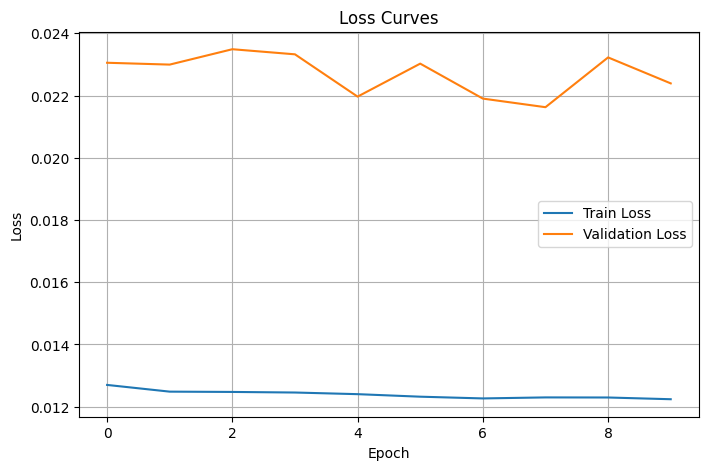

In [30]:
def plot_loss_curves(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.grid()
    plt.show()

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)
plot_loss_curves(history)




# reformat here

In [31]:
#set the random seed
def set_seed(seed= 24):
    os.environ['PYTHONHASHSEED']= str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    torch.use_deterministic_algorithms(True)

set_seed(24)

In [32]:
#define baseline cnn model for bounding box regression
class SimpleBBoxCNN(nn.Module):
 def __init__(self):
   super(SimpleBBoxCNN, self).__init__()
   self.conv1= nn.Conv2d(3, 16, kernel_size= 3, stride= 2, padding= 1)
   self.conv2= nn.Conv2d(16, 32, kernel_size= 3, stride= 2, padding= 1)
   self.conv3= nn.Conv2d(32, 64, kernel_size= 3, stride= 2, padding= 1)
   self.conv4= nn.Conv2d(64, 128, kernel_size= 3, stride= 2, padding= 1)

   #compress dimension
   self.pool= nn.AdaptiveAvgPool2d((1, 1))
   #output x_center, y_center, width, height
   self.fc= nn.Linear(128, 4)

 def forward(self, x):
   x= F.relu(self.conv1(x))
   x= F.relu(self.conv2(x))
   x= F.relu(self.conv3(x))
   x= F.relu(self.conv4(x))
   x= self.pool(x)
   x= x.view(x.size(0), -1)
   x= self.fc(x)
   return x

In [33]:
#define dataset class
class LicensePlateDataset(torch.utils.data.Dataset):
  def __init__(self, image_dir, label_dir, transform= None):
    self.image_dir= image_dir
    self.label_dir= label_dir
    self.image_files= sorted([f for f in os.listdir(image_dir)
                              if f.endswith('.jpg')])
    self.transform= transform

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, idx):
    img_file= self.image_files[idx]
    label_file= os.path.splitext(img_file)[0] + '.txt'
    image_path= os.path.join(self.image_dir, img_file)
    label_path= os.path.join(self.label_dir, label_file)

    image= Image.open(image_path).convert('RGB')

    with open(label_path, 'r') as f:
      line= f.readline().strip()
      parts= line.split()
      bbox= torch.tensor(list(map(float, parts[1:])), dtype= torch.float32)

    if self.transform:
      image= self.transform(image)

    return image, bbox

In [34]:
#create datasets and dataloaders
transform= transforms.Compose([transforms.ToTensor(), ])

#path
base_path= 'data/final_split'

train_dataset= LicensePlateDataset(os.path.join(base_path, 'train/images'),
                                    os.path.join(base_path, 'train/labels'),
                                    transform= transform)

val_dataset= LicensePlateDataset(os.path.join(base_path, 'val/images'),
                                  os.path.join(base_path, 'val/labels'),
                                  transform= transform)

test_dataset= LicensePlateDataset(os.path.join(base_path, 'test/images'),
                                   os.path.join(base_path, 'test/labels'),
                                   transform= transform)

#data loaders
train_loader= DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader= DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader= DataLoader(test_dataset, batch_size=32, shuffle=False)

In [35]:
#function to model trainer
def train_model(model,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                device,
                epochs=10):

    best_val_loss= float('inf')
    history= {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
      print(f"\nEpoch {epoch+1}/{epochs}")
      model.train()
      train_losses= []

      for images, targets in train_loader:
            images, targets= images.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs= model(images)
            loss= criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

      avg_train_loss= np.mean(train_losses)

      #validatiopn
      model.eval()
      val_losses= []


      with torch.no_grad():
            for images, targets in val_loader:
                images, targets= images.to(device), targets.to(device)
                outputs= model(images)
                loss= criterion(outputs, targets)
                val_losses.append(loss.item())

      avg_val_loss= np.mean(val_losses)

      print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

      history['train_loss'].append(avg_train_loss)
      history['val_loss'].append(avg_val_loss)

      #save best model
      if avg_val_loss < best_val_loss:
        best_val_loss= avg_val_loss
        torch.save(model.state_dict(), 'best_bbox_model.pth')
        print("Saved new best model")

    return history

In [36]:
#function to plot loss curves
def plot_loss_curves(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.grid()
    plt.show()

In [37]:
#function to visualize validation predictions
def show_predictions(model, dataloader, device, num_images= 4):
  model.eval()
  images, targets= next(iter(dataloader))
  images, targets= images.to(device), targets.to(device)

  preds= model(images)

  images= images.cpu()
  preds= preds.cpu()
  targets= targets.cpu()

  fig, axes= plt.subplots(1, num_images, figsize= (15, 5))
  for i in range(num_images):
    img= images[i].permute(1, 2, 0).numpy()
    h, w, _= img.shape

    pred_box= preds[i]
    gt_box= targets[i]

    #predicted box
    px1= int((pred_box[0] - pred_box[2] / 2) * w)
    py1= int((pred_box[1] - pred_box[3] / 2) * h)
    px2= int((pred_box[0] + pred_box[2] / 2) * w)
    py2= int((pred_box[1] + pred_box[3] / 2) * h)

    #true box
    gx1= int((gt_box[0] - gt_box[2] / 2) * w)
    gy1= int((gt_box[1] - gt_box[3] / 2) * h)
    gx2= int((gt_box[0] + gt_box[2] / 2) * w)
    gy2= int((gt_box[1] + gt_box[3] / 2) * h)

    axes[i].imshow(img)
    axes[i].add_patch(plt.Rectangle((px1, py1),
                                   px2- px1,
                                   py2- py1,
                                   edgecolor= 'red',
                                   facecolor= 'none',
                                   linewidth= 2))
    axes[i].add_patch(plt.Rectangle((gx1, gy1),
                                   gx2- gx1,
                                   gy2- gy1,
                                   edgecolor= 'green',
                                   facecolor= 'none',
                                   linewidth= 2))
    axes[i].axis('off')

  plt.tight_layout()
  plt.show()

In [38]:
#function to compute IoU for validation set
def compute_iou(box1, box2):
  x1_min= box1[0] - box1[2]/ 2
  x1_max= box1[0] + box1[2]/ 2
  y1_min= box1[1] - box1[3]/ 2
  y1_max= box1[1] + box1[3]/ 2

  x2_min= box2[0] - box2[2]/ 2
  x2_max= box2[0] + box2[2]/ 2
  y2_min= box2[1] - box2[3]/ 2
  y2_max= box2[1] + box2[3]/ 2

  inter_xmin= max(x1_min, x2_min)
  inter_ymin= max(y1_min, y2_min)
  inter_xmax= max(x1_max, x2_max)
  inter_ymax= max(y1_max, y2_max)

  inter_w= max(inter_xmax - inter_xmin, 0)
  inter_h= max(inter_ymax - inter_ymin, 0)
  inter_area= inter_w * inter_h

  area1= (x1_max - x1_min) * (y1_max - y1_min)
  area2= (x2_max - x2_min) * (y2_max - y2_min)

  union_area= area1 + area2 - inter_area

  iou= inter_area / union_area if union_area > 0 else 0
  iou= max(0, min(iou, 1))
  return iou

In [39]:
#function to evaluate iou of model
def evaluate_iou_with_plot(model, loader, device):
  model.eval()
  ious= []

  with torch.no_grad():
    for images, targets in loader:
      images, targets= images.to(device), targets.to(device)
      preds= model(images)

      preds= preds.cpu()
      targets= targets.cpu()

      for pred, target in zip(preds, targets):
        ious.append(compute_iou(pred, target))

  mean_iou= np.mean(ious)

  print(f"Mean IoU: {mean_iou:.4f}")

  #plot iou histogram
  plt.figure(figsize=(8, 5))
  plt.hist(ious, bins=20, color='skyblue', edgecolor='black')
  plt.title("Distribution of IoU scores on Validation Set")
  plt.xlabel("IoU Score")
  plt.ylabel("Frequency")
  plt.grid(True)
  plt.show()

  return ious


Epoch 1/10
Train Loss: 0.1227 | Val Loss: 0.0445
Saved new best model

Epoch 2/10
Train Loss: 0.0166 | Val Loss: 0.0275
Saved new best model

Epoch 3/10
Train Loss: 0.0144 | Val Loss: 0.0249
Saved new best model

Epoch 4/10
Train Loss: 0.0139 | Val Loss: 0.0242
Saved new best model

Epoch 5/10
Train Loss: 0.0135 | Val Loss: 0.0243

Epoch 6/10
Train Loss: 0.0131 | Val Loss: 0.0236
Saved new best model

Epoch 7/10
Train Loss: 0.0130 | Val Loss: 0.0228
Saved new best model

Epoch 8/10
Train Loss: 0.0129 | Val Loss: 0.0235

Epoch 9/10
Train Loss: 0.0129 | Val Loss: 0.0240

Epoch 10/10
Train Loss: 0.0128 | Val Loss: 0.0232


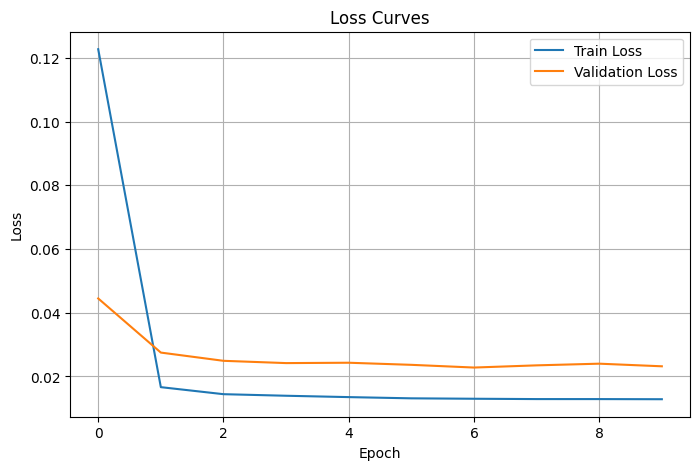

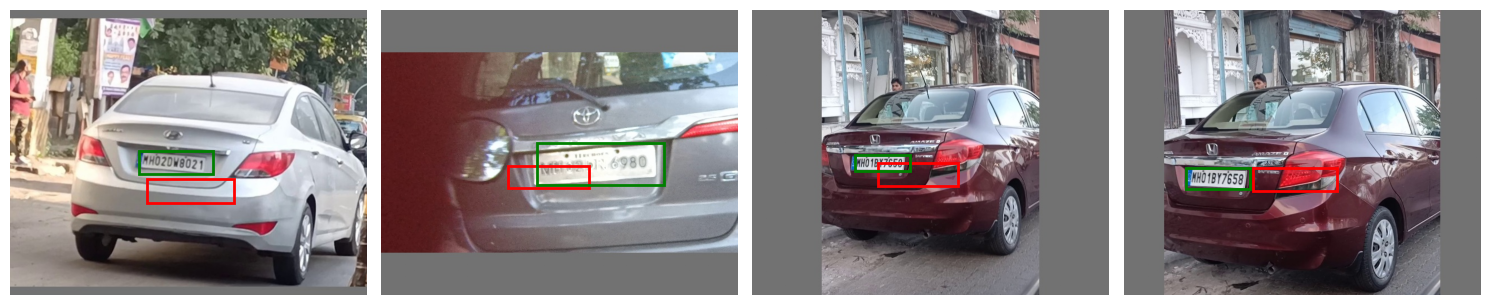

Mean IoU: 0.8128


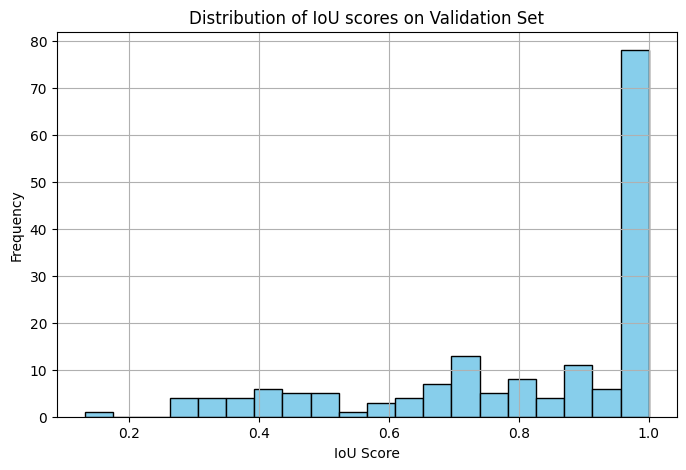

[1,
 tensor(0.6835),
 1,
 1,
 tensor(0.7997),
 tensor(0.7345),
 tensor(0.7612),
 tensor(0.7041),
 tensor(0.7348),
 tensor(0.7166),
 tensor(0.7685),
 tensor(0.7732),
 tensor(0.7381),
 tensor(0.6394),
 tensor(0.8207),
 tensor(0.9246),
 tensor(0.7268),
 tensor(0.6372),
 tensor(0.5725),
 tensor(0.5624),
 tensor(0.3005),
 tensor(0.2845),
 tensor(0.3702),
 tensor(0.3178),
 tensor(0.5067),
 tensor(0.8758),
 tensor(0.8406),
 tensor(0.9101),
 tensor(0.9741),
 1,
 1,
 1,
 tensor(0.7812),
 tensor(0.7099),
 tensor(0.8166),
 tensor(0.6867),
 tensor(0.5090),
 tensor(0.4385),
 tensor(0.3930),
 tensor(0.3833),
 tensor(0.6900),
 tensor(0.9713),
 1,
 1,
 1,
 1,
 1,
 tensor(0.9730),
 1,
 1,
 tensor(0.9765),
 tensor(0.7377),
 1,
 tensor(0.8883),
 tensor(0.7884),
 1,
 tensor(0.3873),
 1,
 1,
 tensor(0.4170),
 1,
 1,
 1,
 1,
 tensor(0.7969),
 tensor(0.7813),
 tensor(0.8455),
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 tensor(0.4780),
 tensor(0.3341),
 tensor(0.5058),
 1,
 1,
 tensor(0.6699),
 tensor(0.8227),
 tensor(0

In [40]:
#run the model and evaluate
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
model= SimpleBBoxCNN().to(device)
criterion= nn.MSELoss()
optimizer= optim.Adam(model.parameters(), lr= 0.0001)

history= train_model(model,
                     train_loader,
                     val_loader,
                     criterion,
                     optimizer,
                     device,
                     epochs= 10)

plot_loss_curves(history)

#load best model (lowest Val loss)
model.load_state_dict(torch.load('best_bbox_model.pth'))
model.to(device)

#visualize validation predictions
show_predictions(model, val_loader, device, num_images= 4)

#evaluate the validation set's IoU
evaluate_iou_with_plot(model, val_loader, device)

i belive that my Iou score is flawed, but from the pricture previous I can tell that my model needs a lot of improvement. here are some ideas i could use to improve the model.

model capacity: deeper/wider CNN
loss function: use a more bounding box aware loss like GIOU
learning rate: tune learning rate, scheduler, and optimizer
data augmentation: random flips, color jitter, rotation
training epochs: increase epochs amount
better transformations: normalize images to mean/std
better initialization: pretrained feature extractions

# lets create a second model

In [41]:
#create second model architecture
class SecondModel(nn.Module):
  def __init__(self):
    super(SecondModel, self).__init__()
    self.conv1= nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
    self.conv2= nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
    self.conv3= nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
    self.conv4= nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
    self.conv5= nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)

    self.pool= nn.AdaptiveAvgPool2d((1, 1))
    self.fc= nn.Linear(512, 4)

  def forward(self, x):
    x= F.relu(self.conv1(x))
    x= F.relu(self.conv2(x))
    x= F.relu(self.conv3(x))
    x= F.relu(self.conv4(x))
    x= F.relu(self.conv5(x))
    x= self.pool(x)
    x= x.view(x.size(0), -1)
    x= self.fc(x)
    return x

In [42]:
#instantiate model
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
second_model= SecondModel().to(device)

In [43]:
#define loss and optimizer
criterion= nn.MSELoss()
optimizer= torch.optim.AdamW(second_model.parameters(), lr=0.0001)

In [44]:
#function to model trainer
def train_model(model,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                device,
                epochs=10):

    best_val_loss= float('inf')
    history= {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
      print(f"\nEpoch {epoch+1}/{epochs}")
      model.train()
      train_losses= []

      for images, targets in train_loader:
            images, targets= images.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs= model(images)
            loss= criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

      avg_train_loss= np.mean(train_losses)

      #validatiopn
      model.eval()
      val_losses= []


      with torch.no_grad():
            for images, targets in val_loader:
                images, targets= images.to(device), targets.to(device)
                outputs= model(images)
                loss= criterion(outputs, targets)
                val_losses.append(loss.item())

      avg_val_loss= np.mean(val_losses)

      print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

      history['train_loss'].append(avg_train_loss)
      history['val_loss'].append(avg_val_loss)

      #save best model
      if avg_val_loss < best_val_loss:
        best_val_loss= avg_val_loss
        torch.save(model.state_dict(), 'second_model_best.pth')
        print("Saved new best model")

    return history

In [ ]:
#train my model
history = train_model(second_model,
                      train_loader,
                      val_loader,
                      criterion,
                      optimizer,
                      device,
                      epochs= 50)

plot_loss_curves(history)

#load best model (lowest Val loss)
model.load_state_dict(torch.load('second_model_best.pth'))
model.to(device)

#visualize validation predictions
show_predictions(model, val_loader, device, num_images= 4)

#evaluate the validation set's IoU
evaluate_iou_with_plot(model, val_loader, device)


Epoch 1/50
Train Loss: 0.0489 | Val Loss: 0.0281
Saved new best model

Epoch 2/50
